# Foundations-2025 — Linear & Logistic Regression (from scratch)

**Purpose:** Implement linear regression (closed-form + gradient descent) and logistic regression (sigmoid + gradient descent) from first principles using **NumPy only**.

**Deliverable:** Clean, annotated implementations and simple experiments demonstrating correctness and evaluation metrics.


## Environment check
Run this cell to confirm Kaggle environment versions (optional).

In [1]:
import sys, platform, numpy as np, sklearn, matplotlib
print('Python:', sys.version.splitlines()[0])
print('Platform:', platform.platform())
print('NumPy:', np.__version__, 'scikit-learn:', sklearn.__version__, 'matplotlib:', matplotlib.__version__)

Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
NumPy: 1.26.4 scikit-learn: 1.2.2 matplotlib: 3.7.2


## Imports & helper functions
We keep imports minimal and define small helpers (RMSE, accuracy).

In [2]:
import numpy as np
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, log_loss
import matplotlib.pyplot as plt

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def add_bias(X):
    """Add a column of ones as bias term."""
    return np.hstack([np.ones((X.shape[0],1)), X])

np.random.seed(0)

## Part A — Linear Regression (Ordinary Least Squares)

### Math intuition
Linear regression assumes a linear model $\hat{y} = X\theta$.  
**Closed-form (Normal equation):** $\theta = (X^\top X)^{-1} X^\top y$ (use pseudo-inverse for stability).  
**Gradient descent:** minimize $J(\theta) = \frac{1}{2m}\|X\theta - y\|^2$ with gradient $\nabla_\theta J = \frac{1}{m} X^\top(X\theta - y)$.

### 1) Synthetic data + Closed-form solution
Create simple regression data and compute closed-form parameters. Evaluate RMSE.

In [3]:
# Synthetic regression dataset
X, y = make_regression(n_samples=500, n_features=3, noise=10.0, random_state=42)
X = add_bias(X)  # bias term
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Closed-form (normal equation with pseudo-inverse for numerical stability)
theta_closed = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ y_train
y_pred_closed = X_test @ theta_closed
print('Closed-form RMSE:', rmse(y_test, y_pred_closed))

# Quick sanity: theta shape
print('theta shape:', theta_closed.shape)

Closed-form RMSE: 10.034963673046196
theta shape: (4,)


### 2) Gradient Descent implementation (batch)
We implement vanilla batch gradient descent. Tune learning rate and iterations.

In [4]:
def gradient_descent_linear(X, y, lr=1e-3, epochs=2000, verbose=False):
    m, n = X.shape
    theta = np.zeros(n)
    history = []
    for epoch in range(epochs):
        preds = X @ theta
        grad = (1/m) * X.T @ (preds - y)
        theta -= lr * grad
        if verbose and epoch % (epochs//5) == 0:
            loss = 0.5 * np.mean((preds - y) ** 2)
            history.append(loss)
            print(f"Epoch {epoch}: loss={loss:.6f}")
    return theta

theta_gd = gradient_descent_linear(X_train, y_train, lr=1e-3, epochs=8000)
y_pred_gd = X_test @ theta_gd
print('GD RMSE:', rmse(y_test, y_pred_gd))

# Compare closed-form vs GD
print('Difference in RMSE (GD - closed):', rmse(y_test, y_pred_gd) - rmse(y_test, y_pred_closed))

GD RMSE: 10.034572416617225
Difference in RMSE (GD - closed): -0.00039125642897097634


### 3) Convergence plot (optional)
Visualize GD convergence on training loss.

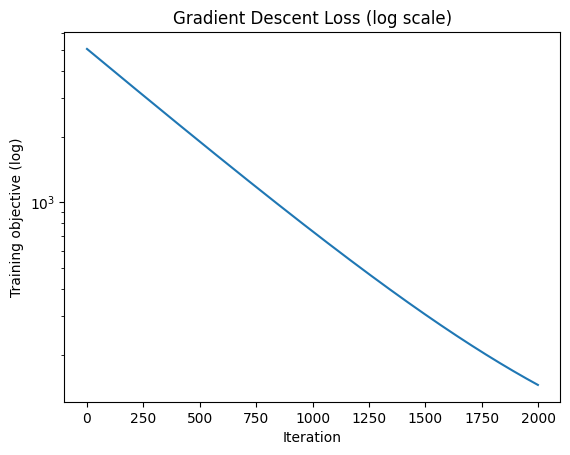

In [5]:
def gradient_descent_with_history(X, y, lr=1e-3, epochs=2000):
    m, n = X.shape
    theta = np.zeros(n)
    hist = np.zeros(epochs)
    for epoch in range(epochs):
        preds = X @ theta
        hist[epoch] = 0.5 * np.mean((preds - y) ** 2)
        grad = (1/m) * X.T @ (preds - y)
        theta -= lr * grad
    return theta, hist

theta_gd2, hist = gradient_descent_with_history(X_train, y_train, lr=1e-3, epochs=2000)
plt.plot(hist)
plt.yscale('log')
plt.title('Gradient Descent Loss (log scale)')
plt.xlabel('Iteration')
plt.ylabel('Training objective (log)')
plt.show()

## Part B — Logistic Regression (Binary classification)

### Math intuition
Logistic regression models $p(y=1|x) = \sigma(Xw)$ where $\sigma(z) = 1/(1+e^{-z})$.  
Loss: Negative log-likelihood (binary cross-entropy). Gradient: $\nabla_w L = \frac{1}{m} X^\top (\hat{p} - y)$. 

We implement sigmoid, gradient descent, and show accuracy + log-loss on synthetic data.

### 1) Sigmoid helper and numerical stability
Implement stable sigmoid and safe log to avoid overflow.

In [6]:
def sigmoid(z):
    """Numerically stable sigmoid"""
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

# Small test
print('sigmoid(0)=', sigmoid(0))
print('sigmoid(10)≈1?', sigmoid(10))

sigmoid(0)= 0.5
sigmoid(10)≈1? 0.9999546021312976


### 2) Synthetic classification data + GD training
Create a synthetic binary dataset and train with NumPy GD.

In [7]:
# Synthetic classification dataset
Xc, yc = make_classification(n_samples=500, n_features=4, n_informative=3, n_redundant=0, random_state=0)
Xc = add_bias(Xc)
Xtr, Xte, ytr, yte = train_test_split(Xc, yc, test_size=0.2, random_state=2)

def gd_logistic(X, y, lr=1e-2, epochs=2000, verbose=False):
    m, n = X.shape
    w = np.zeros(n)
    for ep in range(epochs):
        logits = X @ w
        probs = sigmoid(logits)
        grad = (1/m) * X.T @ (probs - y)
        w -= lr * grad
        if verbose and ep % (epochs//5) == 0:
            loss = -np.mean(y * np.log(probs + 1e-12) + (1 - y) * np.log(1 - probs + 1e-12))
            print(f"Epoch {ep}: loss={loss:.6f}")
    return w

w = gd_logistic(Xtr, ytr, lr=0.05, epochs=4000, verbose=True)
probs_test = sigmoid(Xte @ w)
preds_test = (probs_test >= 0.5).astype(int)
print('Test accuracy:', accuracy_score(yte, preds_test))
print('Test log-loss:', log_loss(yte, probs_test))

Epoch 0: loss=0.693147
Epoch 800: loss=0.474591
Epoch 1600: loss=0.468651
Epoch 2400: loss=0.467945
Epoch 3200: loss=0.467838
Test accuracy: 0.82
Test log-loss: 0.4222717388465783


### 3) Decision boundary visualization (2D toy example)
We visualize decision boundary on a 2D toy dataset (for intuition).

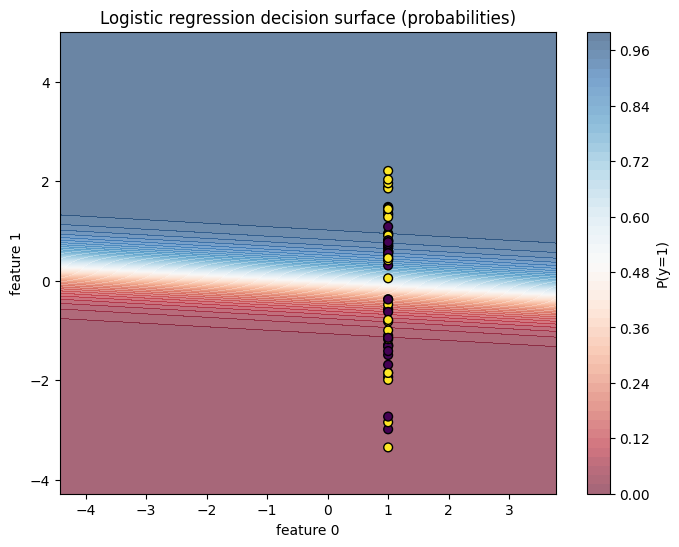

In [8]:
# 2D toy dataset for visualization
X2, y2 = make_classification(n_samples=300, n_features=2, n_informative=2, n_redundant=0, random_state=3)
X2b = add_bias(X2)
X2tr, X2te, y2tr, y2te = train_test_split(X2b, y2, test_size=0.2, random_state=4)

w2 = gd_logistic(X2tr, y2tr, lr=0.05, epochs=2000)

# grid for contour
xx, yy = np.meshgrid(np.linspace(X2[:,0].min()-1, X2[:,0].max()+1, 200),
                     np.linspace(X2[:,1].min()-1, X2[:,1].max()+1, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
gridb = add_bias(grid)
probs_grid = sigmoid(gridb @ w2).reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, probs_grid, levels=50, cmap='RdBu', alpha=0.6)
plt.colorbar(label='P(y=1)')
plt.scatter(X2te[:,0], X2te[:,1], c=y2te, edgecolor='k', s=40)
plt.title('Logistic regression decision surface (probabilities)')
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.show()

## Part C — Notes, diagnostics & extensions
**Diagnostics:**  
- If GD converges slowly: try learning rate scheduling, feature scaling (standardize features), or use mini-batch SGD.  
- For classification, monitor both **accuracy** and **log-loss**; log-loss is more informative for probabilistic calibration.  
- Closed-form solution is great for small feature counts; for large-scale problems use iterative methods (GD, SGD, LBFGS).

**Extensions you can add:**  
- Regularization (L2/Ridge: add λ * I to XᵀX before inversion; for GD add λ*w to gradient).  
- Mini-batch/SGD with shuffle and learning-rate decay.  
- Multiclass logistic (softmax) from scratch.  
- Add model cards and markdown describing experiment design for your portfolio.

## Part D — Quick checklist before adding to GitHub / Kaggle portfolio
1. Clean cell outputs (clear unnecessary prints) for publication.  
2. Add a short `README.md` describing the notebook objective, dataset, and how to run.  
3. Include a `requirements.txt` if you convert into a repo (most Kaggle kernels already have required libs).  
4. Add a `model_card.md` describing the limitations and use-cases.